In [1]:
import time
import statistics
import serial
import serial.tools.list_ports
import ipywidgets as widgets
import ipysheet
import matplotlib.pyplot as plt 

%matplotlib widget
plt.rcParams['animation.html']='jshtml'
from sklearn.linear_model import LinearRegression
import numpy as np

In [29]:
com_ports=serial.tools.list_ports.comports()
ports=[]
for p in com_ports:
    ports.append(p.device)

com_port=widgets.Dropdown(
    options=ports,
    description='Virtual serial device:',
    disabled=False
)
com_port.style.description_width='150px'
display(com_port)

Dropdown(description='Virtual serial device:', options=('/dev/ttyS31', '/dev/ttyS30', '/dev/ttyS29', '/dev/tty…

In [3]:
arduino_connect_button = widgets.Button(
    description='Connetti Arduino',
    disabled=False,
    button_style='', 
    tooltip='Start Arduino connection',
    icon='plug' 
)
output = widgets.Output(layout={'border': '2px solid black'})

arduino=None
def connect_arduino(b):
    global arduino
    arduino=serial.Serial(com_port.value, baudrate=115200, timeout=1)
    test=2
    with output:
        print("Arduino connected")

arduino_connect_button.on_click(connect_arduino)
display(arduino_connect_button,output)


Button(description='Connetti Arduino', icon='plug', style=ButtonStyle(), tooltip='Click me')

Output(layout=Layout(border_bottom='2px solid black', border_left='2px solid black', border_right='2px solid b…

In [4]:
handshake_button = widgets.Button(
    description='Handshake Arduino',
    disabled=False,
    button_style='', 
    tooltip='Microcontroller handshake',
    icon='handshake'
)
handshake_output = widgets.Output(layout={'border': '2px solid black'})
handshake_output.clear_output()

def handshake_arduino(sleep_time=1):

    timeout = arduino.timeout
    arduino.timeout = 2
    arduino.write('h'.encode())
    
    while (arduino.in_waiting < 0):
        pass
    
    response= arduino.read_until()
    arduino.timeout = timeout
    with handshake_output:
        
        print(response.decode().strip())
        
handshake_button.on_click(handshake_arduino)
display(handshake_button,handshake_output)


Button(description='Handshake Arduino', icon='handshake', style=ButtonStyle(), tooltip='Click me')

Output(layout=Layout(border_bottom='2px solid black', border_left='2px solid black', border_right='2px solid b…

In [5]:
def parse_raw_line(raw_line):
    raw_line = raw_line.decode()
    if raw_line[-1] != "\n":
        raise ValueError(
            "Il messaggio inviato da Arduino deve terminare con il carattere nuova linea."
        )
    
    broadband,ir= raw_line.rstrip().split("|")

    return int(broadband),int(ir)

In [30]:
samples=widgets.Dropdown(
    options=range(1,16),
    description='Samples (number):',
    disabled=False,
)
samples.style.description_width='150px'
integration_time=widgets.Dropdown(
                    options=[13,102,402],
                    value=402,
                    description='Integration time (ms):',
                    disabled=False,
                   
)
integration_time.style.description_width='150px'
measure_output = widgets.Output(layout={'border': '2px solid black'})

TSL2561_CLIPPING_402MS:int=65000
TSL2561_LUX_CHSCALE:int=10
TSL2561_LUX_RATIOSCALE:int =9

def calculateLux(broadband:int,ir:int):
    clipThreshold = TSL2561_CLIPPING_402MS
    chScale = (1 << TSL2561_LUX_CHSCALE)
    channel0:int = (broadband * chScale) >> TSL2561_LUX_CHSCALE
    channel1:int = (ir * chScale) >> TSL2561_LUX_CHSCALE
    ratio:float=0
    lux:float=0
    if (channel0 != 0):
        ratio =channel1/channel0
        
    if ratio>0 and ratio <=0.5:
        lux=0.0304*channel0-0.062*channel0*pow(ratio,1.4)
    elif ratio>0.5 and ratio<=0.61:
        lux=0.0224*channel0-0.031*channel1
    elif ratio>0.61 and ratio <=0.80:
        lux=0.0128*channel0-0.0153*channel1
    elif ratio>0.80 and ratio <=1.30:
        lux=0.00146*channel0-0.00112*channel1
    elif ratio>1.30 and ratio <=3.00:
        lux=0.0
    
    return round(lux,1)


@measure_output.capture()
def get_light_reading(b):
    #n_samples: average over n_samples
    #sensor integration time, defaults to 402ms
    broadband_readings=[]
    ir_readings=[]
    n_samples=samples.value
    int_time=integration_time.value
    
    for reading in range(n_samples):
            # invio il comando per la lettura del sensore TSL2561
            arduino.write('r'.encode())
            while arduino.in_waiting < 0:
                pass
            # Leggo i dati inviati tramite seriale a seguito della richiesta di lettura
            raw = arduino.read_until()
    
            broadband,ir=parse_raw_line(raw)
            broadband_readings.append(broadband)
            ir_readings.append(ir)
            time.sleep(1.5*int_time/1000)
        
    lux_data=calculateLux(int(statistics.mean(broadband_readings)),int(statistics.mean(ir_readings)))
    print(lux_data)
    return lux_data

measure_button = widgets.Button(
    description='Measure light',
    disabled=False,
    button_style='', 
    tooltip='Get a single illuminance reading',
    icon='ruler'
)

measure_button.on_click(get_light_reading)

selection_lists=widgets.HBox([samples,integration_time])
widgets.VBox([selection_lists,measure_button,measure_output])
    

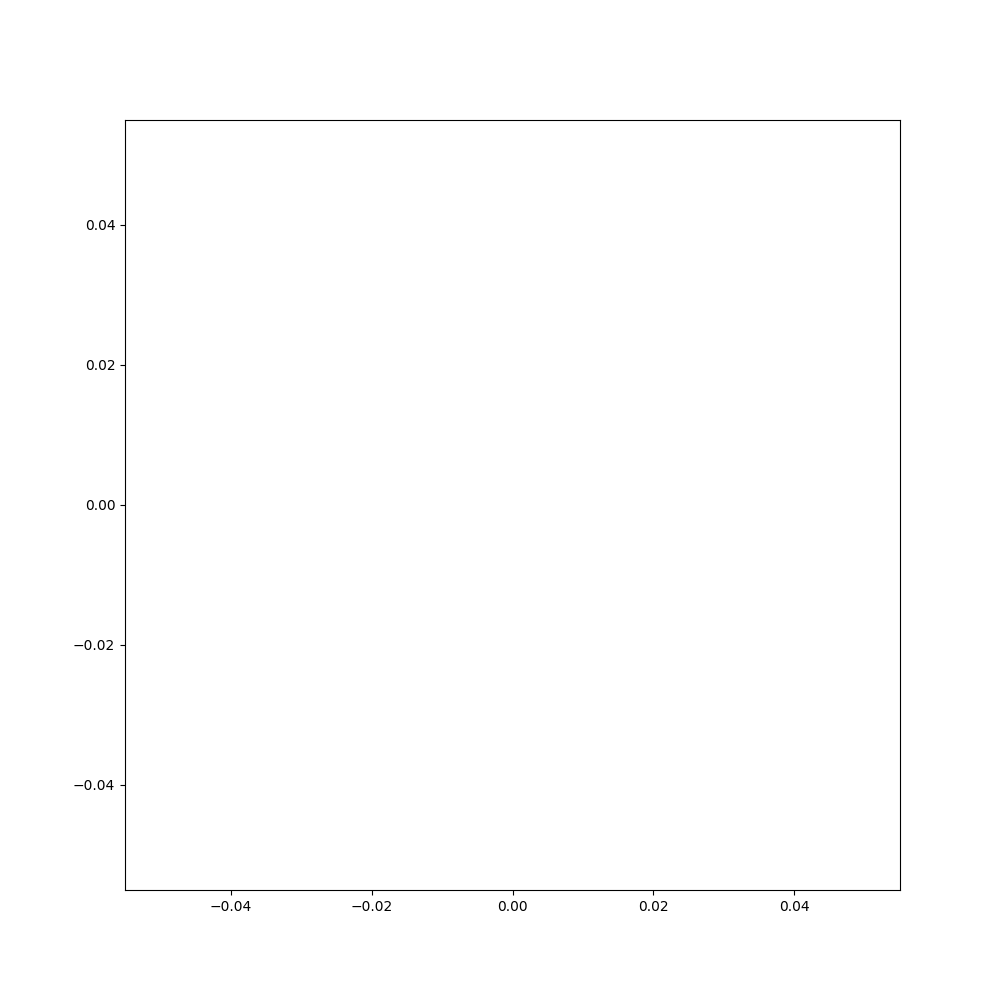

In [12]:
n_rows=10
n_columns=2
sheet_output = widgets.Output(layout={'border': '2px solid black'})
experiment_data=ipysheet.sheet(rows=n_rows, columns=n_columns, column_headers=["Molarity (mol/L)","Illuminance (Lux)"], row_headers=False)
cells=[[ipysheet.cell(i,j,value=0.0) for j in range(n_columns)] for i in range(n_rows)]
cells_data=[[cells[i][j].value for j in range(n_columns)] for i in range(n_rows)]

#create matplotlib figure
regfigure,regax= plt.subplots(figsize=[10,10])
regscatter, = regax.plot([], [], 'bo', label='Illuminance vs Molarity')
#setup reg lines and plot intervals
regline1, = regax.plot([], [], 'r', label='Absorbance calibration curve')


@sheet_output.capture()
def get_reg_coeff():
   
    #molarity and illuminance
    molarity_data=[measure[0] for measure in cells_data if measure[0]>0]
    illuminance_data=[measure[1] for measure in cells_data if measure[1]>0 ]
    #create  slice objects
    regd1=slice(0,len(molarity_data))
   
    plt.grid()
    plt.xlabel('Molarity (mol/L)')
    plt.ylabel('Illuminance (Lux)')

    regax.set_xlim(min(molarity_data)-1, max(molarity_data)+1)
    regax.set_ylim(min(illuminance_data)-1,max(illuminance_data)+1)
    regax.legend()


    #do the linear reg
    reg1 = LinearRegression()
    x_train1 = np.array(molarity_data[regd1]).reshape(-1, 1)
    y_train1 = np.array(illuminance_data[regd1]).reshape(-1, 1)
    reg1.fit(x_train1,y_train1)
    
    #collect results
    lines_data=[reg1.coef_[0][0],reg1.intercept_[0]]
    print(lines_data)
    #plot data
    regscatter.set_data(molarity_data,illuminance_data)
    regline1.set_data(molarity_data, reg1.predict(np.array([entry for entry in molarity_data]).reshape(-1, 1)))
    
    return lines_data



@sheet_output.capture()
def measure_light(change):
    illuminance=get_light_reading('test')
    
    cells[change.owner.row_start][change.owner.column_start+1].value=illuminance
    for k in range(2):
        cells_data[change.owner.row_start][k]=cells[change.owner.row_start][k].value
        
    
    get_reg_coeff()
    #plot_data()
    
for i in range(n_rows):
    cells[i][0].observe(measure_light, 'value')
    
widgets.VBox([experiment_data, sheet_output])

